In [2]:
import numpy as np
import matplotlib.pylab as plt
import os
import xarray as xr
import seawater as sw
#from mpl_toolkits.basemap import Basemap
from IPython.core.debugger import set_trace

debug_here = set_trace

plots_dir = '../plots/misc/'
fz = 14

data_dir = '/Users/ewilson2011/Documents/Southern_Ocean/data/ERA5/'  
fname = 'tau-40S.nc'
#lsm_file = 'lsm-40S-v2.nc'
lsm_file = 'sst-40S.nc'
sf =  # secs in day
taux_vname = 'ewss'
tauy_vname = 'nsss'

In [3]:
ls_ds = xr.open_dataset(os.path.join(data_dir, lsm_file))
land_sea_mask = np.ma.masked_invalid(ls_ds['sst'][0, :, :]).mask

ds = xr.open_dataset(os.path.join(data_dir, fname))
#debug_here()
lats = ds['latitude']
lons = ds['longitude']

In [4]:
print(ds)

<xarray.Dataset>
Dimensions:    (latitude: 161, longitude: 1440, time: 12)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.75 -179.5 ... 179.25 179.5 179.75
  * latitude   (latitude) float32 -40.0 -40.25 -40.5 ... -79.5 -79.75 -80.0
  * time       (time) datetime64[ns] 2019-01-01 2019-02-01 ... 2019-12-01
Data variables:
    ewss       (time, latitude, longitude) float32 ...
    nsss       (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-04-16 22:51:23 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...


In [5]:
print(ds['ewss'])

<xarray.DataArray 'ewss' (time: 12, latitude: 161, longitude: 1440)>
[2782080 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.75 -179.5 ... 179.25 179.5 179.75
  * latitude   (latitude) float32 -40.0 -40.25 -40.5 ... -79.5 -79.75 -80.0
  * time       (time) datetime64[ns] 2019-01-01 2019-02-01 ... 2019-12-01
Attributes:
    units:          N m**-2 s
    long_name:      Eastward turbulent surface stress
    standard_name:  surface_downward_eastward_stress


convert to N/m2. Accumulation time is 1 day

In [20]:
ds_Nm2 = ds/(3600*24)

taux = ds_Nm2['ewss']
tauy = ds_Nm2['nsss']

get points along 72.67 S, 88.00 W;  70.04 S, 75.87 W

Text(0.5, 0, 'Longitude')

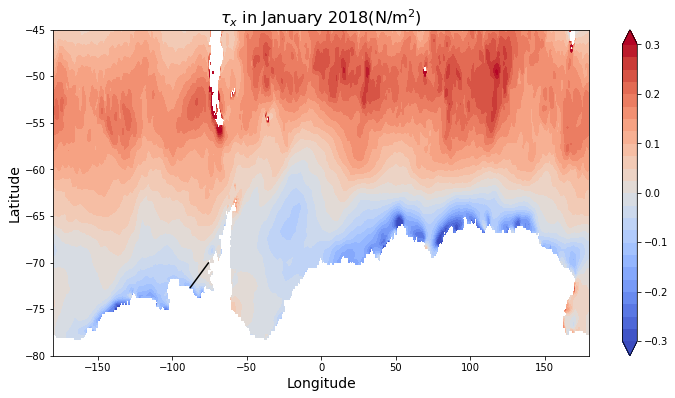

In [53]:
x0, y0 = -88.00, -72.67
x1, y1 = -75.87, -70.04

# make test plot to visualize
plt.figure(figsize=(12, 6))
LONS, LATS = np.meshgrid(lons, lats)
clvls = np.arange(-0.3, 0.31, 0.025)
taux1_ma = np.ma.masked_where(land_sea_mask, taux[1, :, :])
im = plt.contourf(LONS, LATS, taux1_ma, clvls, vmin=-0.3, vmax=0.3, cmap=plt.cm.coolwarm, extend='both')
plt.plot([x0, x1], [y0, y1], color='k')
plt.colorbar(im, extend='both', ticks=clvls[::4])
plt.ylim(-80, -45)
plt.title(r"$\tau_x$ in January 2018(N/m$^2$)", fontsize=fz+2)
plt.ylabel("Latitude", fontsize=fz)
plt.xlabel("Longitude", fontsize=fz)

In [58]:
# get points along line
m = (y1-y0)/(x1-x0)

x_res = np.abs(np.diff(lons)[0])
x = np.arange(x0, x1+x_res, x_res)
y = y0 + (x-x0)*m
line_coords = np.vstack((x,y)).T
#print(line_coords)

Text(0.5, 0, 'Longitude')

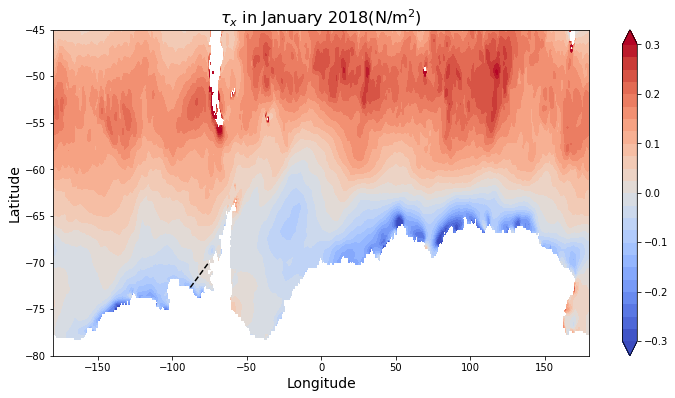

In [57]:
# make test plot to visualize
plt.figure(figsize=(12, 6))
LONS, LATS = np.meshgrid(lons, lats)
clvls = np.arange(-0.3, 0.31, 0.025)
taux1_ma = np.ma.masked_where(land_sea_mask, taux[1, :, :])
im = plt.contourf(LONS, LATS, taux1_ma, clvls, vmin=-0.3, vmax=0.3, cmap=plt.cm.coolwarm, extend='both')
plt.plot(x, y, '--k')
plt.colorbar(im, extend='both', ticks=clvls[::4])
plt.ylim(-80, -45)
plt.title(r"$\tau_x$ in January 2018(N/m$^2$)", fontsize=fz+2)
plt.ylabel("Latitude", fontsize=fz)
plt.xlabel("Longitude", fontsize=fz)

In [69]:
# select data along line
lon_grid_vec = LONS.flatten()
lat_grid_vec = LATS.flatten()

min_idx = []
for i in range(len(x)):
    dist = np.sqrt((x[i]-lon_grid_vec)**2 + (y[i]-lat_grid_vec)**2)
    min_idx.append(np.argmin(dist))

min_idx = np.array(min_idx)
nearest_lons, nearest_lats  = lon_grid_vec[min_idx], lat_grid_vec[min_idx]
nearest_coords = np.vstack((nearest_lons, nearest_lats)).T

taux_line = np.zeros((len(x), 12))
tauy_line = np.zeros((len(x), 12))

for i in range(12):
    taux_m_vec = taux[i,...].values.flatten()
    tauy_m_vec = tauy[i,...].values.flatten()
    
    taux_line[:, i] = taux_m_vec[min_idx]
    tauy_line[:, i] = tauy_m_vec[min_idx]                  

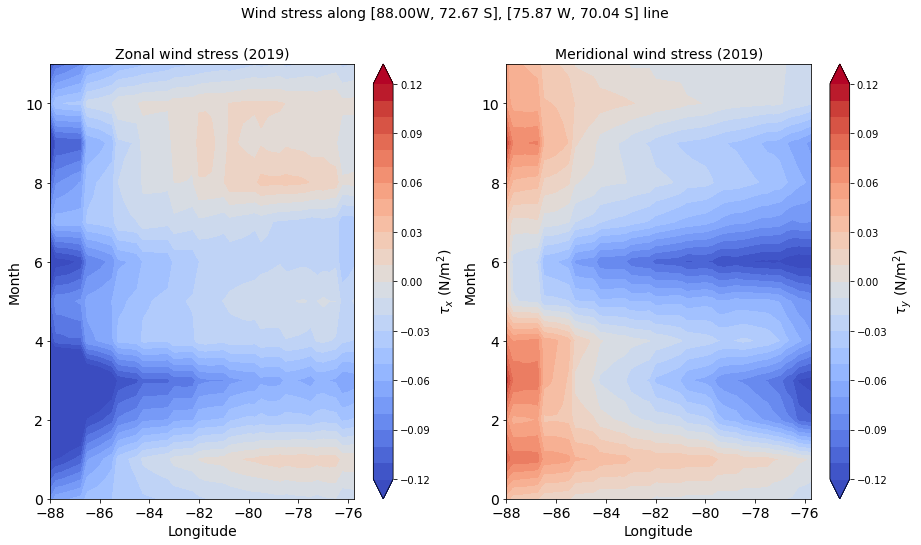

In [91]:
plt.figure(figsize=(15, 8))

clvls = np.arange(-0.12, 0.1201, 0.01)
plt.subplot(121)
plt.contourf(nearest_lons, range(12), taux_line.T, clvls, vmin=clvls[0], vmax=clvls[-1], 
             cmap=plt.cm.coolwarm, extend='both')
plt.xlabel("Longitude", fontsize=fz)
plt.ylabel("Month", fontsize=fz)
plt.title("Zonal wind stress (2019)", fontsize=fz)
cbar = plt.colorbar(extend='both')
cbar.ax.set_ylabel(r"$\tau_x$ (N/m$^2$)", fontsize=fz)
plt.gca().tick_params(axis='both', which='major', labelsize=fz)

plt.subplot(122)
plt.contourf(nearest_lons, range(12), tauy_line.T, clvls, vmin=clvls[0], vmax=clvls[-1],
             cmap=plt.cm.coolwarm, extend='both')
plt.xlabel("Longitude", fontsize=fz)
plt.ylabel("Month", fontsize=fz)
plt.title("Meridional wind stress (2019)", fontsize=fz)
cbar = plt.colorbar(extend='both')
cbar.ax.set_ylabel(r"$\tau_y$ (N/m$^2$)", fontsize=fz)
plt.gca().tick_params(axis='both', which='major', labelsize=fz)

plt.suptitle("Wind stress along [88.00W, 72.67 S], [75.87 W, 70.04 S] line", fontsize=fz)

plt.subplots_adjust(hspace=0.5)